# Melt, Weather --> LSTM --> streamflow

In [185]:
#first: are you working in colab?
colab = 0

if colab:
    
    #mount drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'
    
else:
    
    dataPath = ''


In [178]:
#import required libraries
import pandas as pd
import numpy as np
#from netCDF4 import Dataset
from keras.layers import Dense, LSTM, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import pickle
import matplotlib.pyplot as plt

In [186]:
M = pd.read_csv(dataPath + 'stationGlacierMelt.csv',header=None)

pickle_in = open(dataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'relHDict.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'ssrdDict.pickle','rb')
ssrdDict = pickle.load(pickle_in)

#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

In [142]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])
M = np.asarray(M.iloc[:,indStartERA:])

##just alberta
#T = T[:,:15,29:]
#P = P[:,:15,29:]
#H = H[:,:15,28:]
#S = S[:,:15,28:]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [143]:
#loop through stations and find the closest era grid cell

stationT = np.empty((len(stationLat),len(eraDays)))
stationP = np.empty((len(stationLat),len(eraDays)))
stationH = np.empty((len(stationLat),len(eraDays)))
stationS = np.empty((len(stationLat),len(eraDays)))
stationM = np.empty((len(stationLat),len(eraDays)))

for kk in range(len(stationLat)): #for each station
    
    dlat = np.min(np.abs(stationLat[kk] - eraLat))
    indLat = np.argwhere(np.abs(stationLat[kk] - eraLat) == dlat)[0]
    dlon = np.min(np.abs(stationLon[kk] - eraLon))
    indLon = np.argwhere(np.abs(stationLon[kk] - eraLon) == dlon)[0]
    
    stationT[kk] = np.squeeze(T[:,indLat,indLon])
    stationP[kk] = np.squeeze(P[:,indLat,indLon])
    stationH[kk] = np.squeeze(H[:,indLat,indLon])
    stationS[kk] = np.squeeze(S[:,indLat,indLon])
    stationM[kk] = np.squeeze(M[kk])
    
#use only stations with glaciers
stationsWithGlaciers = np.squeeze(np.argwhere(np.sum(stationM,axis=1)>0))
stationT = stationT[stationsWithGlaciers,:]
stationP = stationP[stationsWithGlaciers,:]
stationH = stationH[stationsWithGlaciers,:]
stationS = stationS[stationsWithGlaciers,:]
stationM = stationM[stationsWithGlaciers,:]
F = F[:,stationsWithGlaciers]

#normalize
stationT = (stationT - np.mean(stationT))/np.std(stationT)
stationP = (stationP - np.mean(stationP))/np.std(stationP)
stationH = (stationH - np.mean(stationH))/np.std(stationH)
stationS = (stationS - np.mean(stationS))/np.std(stationS)
stationM = (stationM - np.mean(stationM))/np.std(stationM)

In [144]:
for station in range(np.shape(F)[1]):
    F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])

In [165]:
#create input/output datasets

num_obs = (len(eraDays) - 365) * len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0

for station in range(len(stationsWithGlaciers)): #for each station
    
    for day in range(len(eraDays)-365): #for each day of flow
        
        x[jj,:,0] = stationT[station,day:day+365]
        x[jj,:,1] = stationP[station,day:day+365]
        x[jj,:,2] = stationH[station,day:day+365]
        x[jj,:,3] = stationS[station,day:day+365]
        x[jj,:,4] = stationM[station,day:day+365]
        y[jj] = F[day+365,station]
        jj+=1
    

In [173]:
#split into train/test
fracTrain = 0.8
Ntrain = int(fracTrain * len(x))

x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

In [183]:
#build model

model = Sequential()
model.add(LSTM(20, input_shape = (365,5), return_sequences=True))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss = 'mse', optimizer='adam')
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 365, 20)           2080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 7300)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7301      
Total params: 9,381
Trainable params: 9,381
Non-trainable params: 0
_________________________________________________________________


In [184]:
#train model
history = model.fit(x_train,y_train, validation_split = 0.2, epochs = 1, batch_size=64,verbose=1, callbacks = [es])

Train on 96779 samples, validate on 24195 samples
Epoch 1/1
 1856/96779 [..............................] - ETA: 38:26 - loss: 0.3836

KeyboardInterrupt: 

In [182]:
np.shape(y_test)

(30244,)

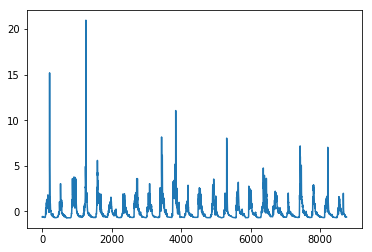

In [151]:
plt.plot(F.T[-1])

In [82]:
indLat

array([14])

In [84]:
len(stationT[0])

8766

In [86]:
stationT[0,10]

274.8078620617497